In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.colors import LogNorm
import cv2
import os

Filename: IC3392_DESI_gi.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   (3000, 3000, 2)   float32   
SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                  -32 / number of bits per data pixel                  NAXIS   =                    3 / number of data axes                            NAXIS1  =                 3000 / length of data axis 1                          NAXIS2  =                 3000 / length of data axis 2                          NAXIS3  =                    2 / length of data axis 3                          EXTEND  =                    T / FITS dataset may contain extensions            COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H SURVEY  = 'LegacySurvey'                                                        VERSION = 'DR10    '                 

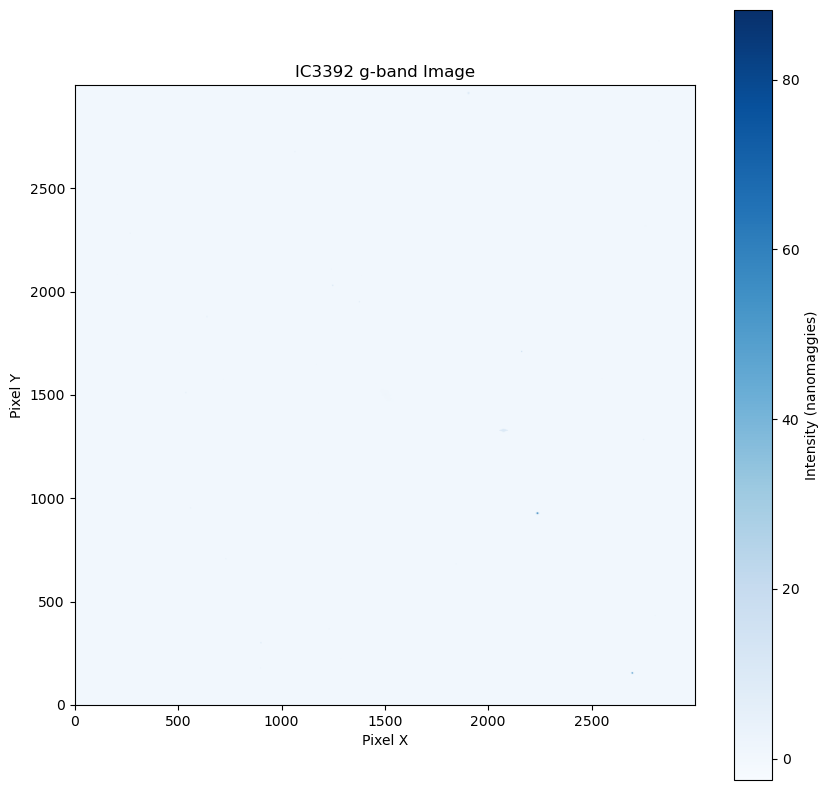

maximum value in g-band flux: 88.218956
minimum value in g-band flux: -2.5115538
maximum value in i-band flux: 40.601494
minimum value in i-band flux: -2.0090156
maximum value in g-band flux: (np.int64(928), np.int64(2237))
maximum value in i-band flux: (np.int64(301), np.int64(899))


In [2]:
# Load the FITS file (update the filename as needed)
filename = "IC3392_DESI_gi.fits"
object_name = filename.split('_')[0]
hdul = fits.open(filename)

# Display the structure of the FITS file
hdul.info()

# Assuming the image data is in the primary HDU (index 0)
data = hdul[0].data

# Optionally, print header information to see details about the observation
header = hdul[0].header
print(header)

# Close the FITS file after loading data (optional but recommended)
hdul.close()

g_band_flux = data[0]  # Assuming the first slice is the g-band flux
i_band_flux = data[1]  # Assuming the second slice is the i-band flux

# Plot the data using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(g_band_flux, cmap='Blues', origin='lower')
plt.colorbar(label='Intensity (nanomaggies)')
plt.title(f"{object_name} g-band Image")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

# Check satruration
print("maximum value in g-band flux:", np.max(g_band_flux))
print("minimum value in g-band flux:", np.min(g_band_flux))
print("maximum value in i-band flux:", np.max(i_band_flux))
print("minimum value in i-band flux:", np.min(i_band_flux))
# localize the maxinum value
print("maximum value in g-band flux:", np.unravel_index(np.argmax(g_band_flux), g_band_flux.shape))
print("maximum value in i-band flux:", np.unravel_index(np.argmax(i_band_flux), i_band_flux.shape))

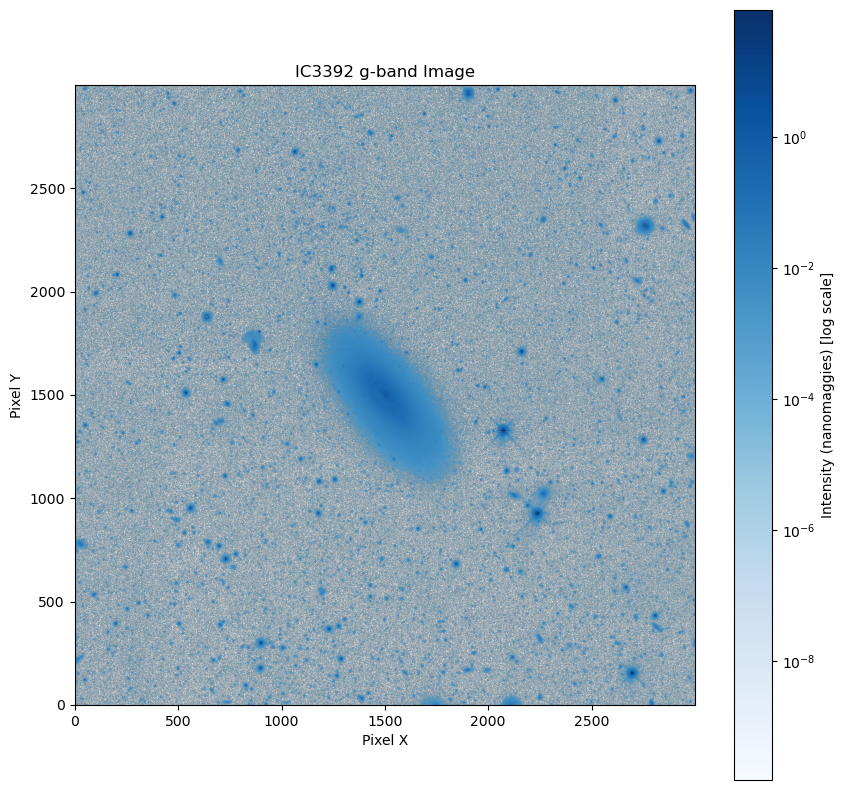

In [3]:
plt.figure(figsize=(10, 10))
# use only positive values for log scaling
vmin = g_band_flux[g_band_flux > 0].min()
vmax = g_band_flux.max()
im = plt.imshow(g_band_flux, cmap='Blues', origin='lower',
                norm=LogNorm(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(im)
cbar.set_label('Intensity (nanomaggies) [log scale]')

plt.title(f"{object_name} g-band Image")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

Extinction for IC3392: {'g': 0.11859660000000001, 'i': 0.05874480000000001}
g-band galactic extinction correction applied
i-band galactic extinction correction applied


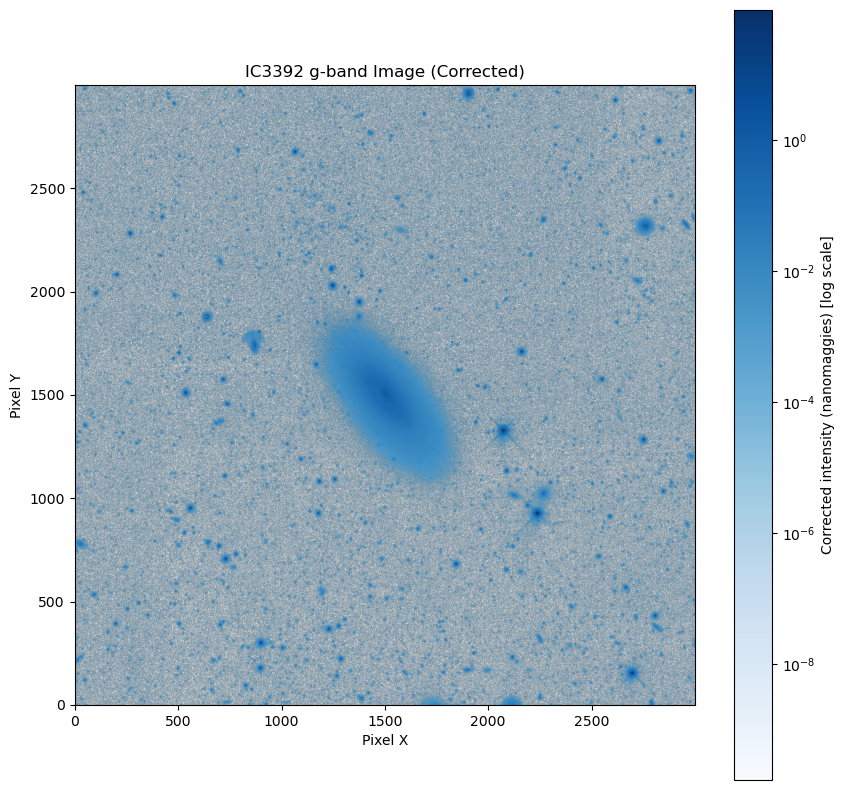

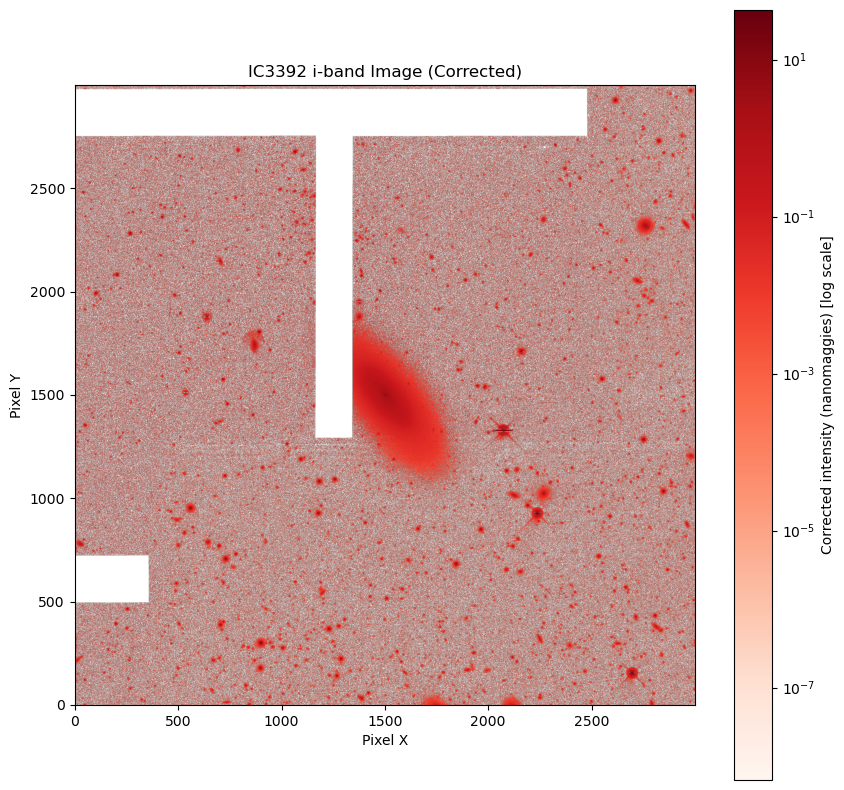

In [4]:
# correction for galactic extinction
# Universal E(B-V) lookup (Corteste et al. 2012)
Extinction_lookup = {
    "IC3392": 0.0369,
    "NGC4383": 0.0237, 
    "NGC4501": 0.0380, 
    "NGC4192": 0.0350, 
}
Extinction = Extinction_lookup.get(object_name, 0.030)  # Default to 0.030 if not found

# Bandpass lookup (https://www.legacysurvey.org/dr9/catalogs/#galactic-extinction-coefficients)
# These coefficients are 𝐴/𝐸(𝐵−𝑉) = 3.995, 3.214, 2.165, 1.592, 1.211, 1.064 for the DECam 𝑢griz𝑌 filters
Extinction_coefficients = {
    # "u": 3.995,
    "g": 3.214,
    # "r": 2.165,
    "i": 1.592,
    # "z": 1.211,
    # "Y": 1.064,
}
# Calculate the extinction for each band for the input object
def calculate_extinction(object_name, Extintion, Extintion_coefficients):
    extinction = {}
    for band, coeff in Extintion_coefficients.items():
        extinction[band] = coeff * Extintion
    return extinction
extinction = calculate_extinction(object_name, Extinction, Extinction_coefficients)
print(f"Extinction for {object_name}: {extinction}")

# Apply the extinction correction to the g-band and i-band flux
def apply_extinction_correction(flux, extinction, band):
    coeff = extinction[band]
    corrected_flux = flux * 10**(0.4 * coeff)
    return corrected_flux
g_band_flux_corrected = apply_extinction_correction(g_band_flux, extinction, "g")
i_band_flux_corrected = apply_extinction_correction(i_band_flux, extinction, "i")  
print("g-band galactic extinction correction applied")
print("i-band galactic extinction correction applied") 

# Plot the corrected g-band image
plt.figure(figsize=(10, 10))
vmin = g_band_flux_corrected[g_band_flux_corrected > 0].min()
vmax = g_band_flux_corrected.max()
im = plt.imshow(g_band_flux_corrected, cmap='Blues', origin='lower',
                norm=LogNorm(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(im)
cbar.set_label('Corrected intensity (nanomaggies) [log scale]')
plt.title(f"{object_name} g-band Image (Corrected)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()
# Plot the corrected i-band image
plt.figure(figsize=(10, 10))
vmin = i_band_flux_corrected[i_band_flux_corrected > 0].min()
vmax = i_band_flux_corrected.max()
im = plt.imshow(i_band_flux_corrected, cmap='Reds', origin='lower',
                norm=LogNorm(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(im)
cbar.set_label('Corrected intensity (nanomaggies) [log scale]')
plt.title(f"{object_name} i-band Image (Corrected)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

g-band noise level: 2.801438808441162
i-band noise level: 2.1207096576690674
nanomaggies to magnitudes conversion done.
g-band magnitude range: 46.94 to 17.52
i-band magnitude range: 42.94 to 18.42


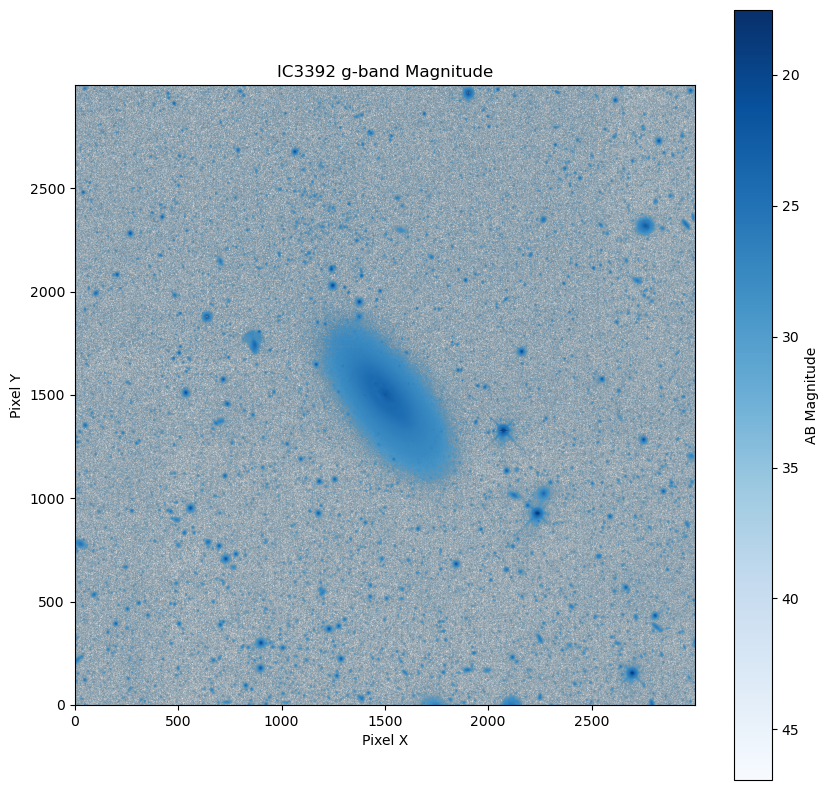

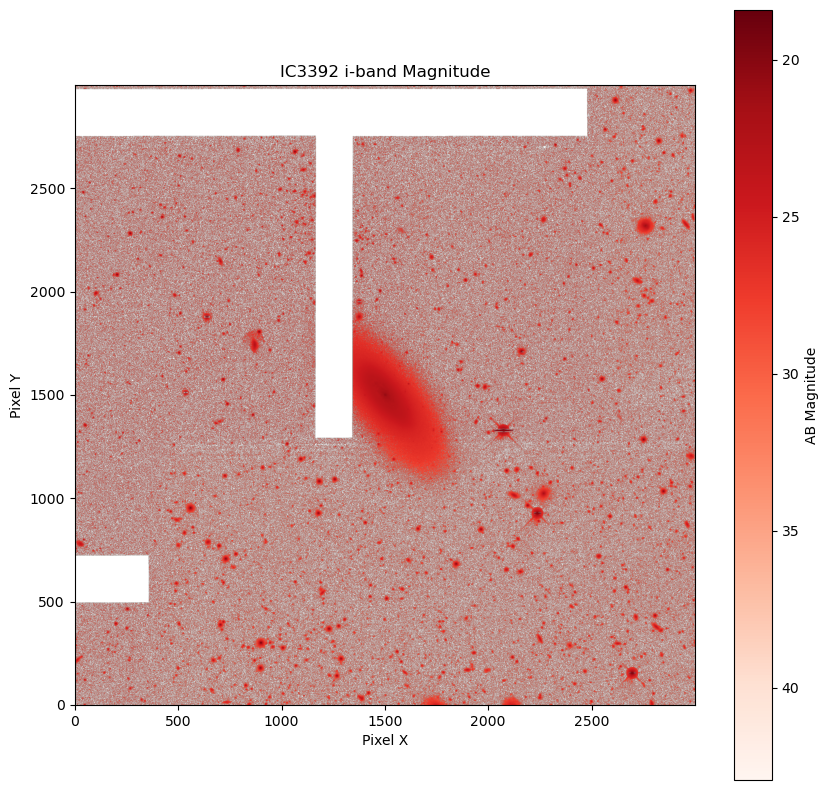

In [5]:
# Check background noise level
g_band_flux_noise = np.max(np.abs(g_band_flux_corrected[g_band_flux<0]))
i_band_flux_noise = np.max(np.abs(i_band_flux_corrected[i_band_flux<0]))
print(f"g-band noise level: {g_band_flux_noise}")
print(f"i-band noise level: {i_band_flux_noise}")

# Get valid flux (negative values are set to nan)
g_band_flux_corrected[g_band_flux_corrected <= 0] = np.nan
i_band_flux_corrected[i_band_flux_corrected <= 0] = np.nan

# Convert nanomaggies to magnitudes
# The conversion from linear fluxes to magnitudes is 𝑚=22.5−2.5log10(flux)
g_band_magnitude = 22.5 - 2.5 * np.log10(g_band_flux_corrected)
i_band_magnitude = 22.5 - 2.5 * np.log10(i_band_flux_corrected)

print("nanomaggies to magnitudes conversion done.")
# Check the range of magnitudes
print(f"g-band magnitude range: {np.nanmax(g_band_magnitude):.2f} to {np.nanmin(g_band_magnitude):.2f}")
print(f"i-band magnitude range: {np.nanmax(i_band_magnitude):.2f} to {np.nanmin(i_band_magnitude):.2f}")

# Plot the g-band and i-band magnitudes
plt.figure(figsize=(10, 10))
plt.imshow(g_band_magnitude, cmap='Blues_r', origin='lower')
cbar = plt.colorbar(label='AB Magnitude')
cbar.ax.invert_yaxis()
plt.title(f"{object_name} g-band Magnitude")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(i_band_magnitude, cmap='Reds_r', origin='lower')
cbar = plt.colorbar(label='AB Magnitude')
cbar.ax.invert_yaxis()
plt.title(f"{object_name} i-band Magnitude")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

g-band isophotal threshold in pixel scale: 27.41 mag/pixel^2
i-band isophotal threshold in pixel scale: 26.41 mag/pixel^2


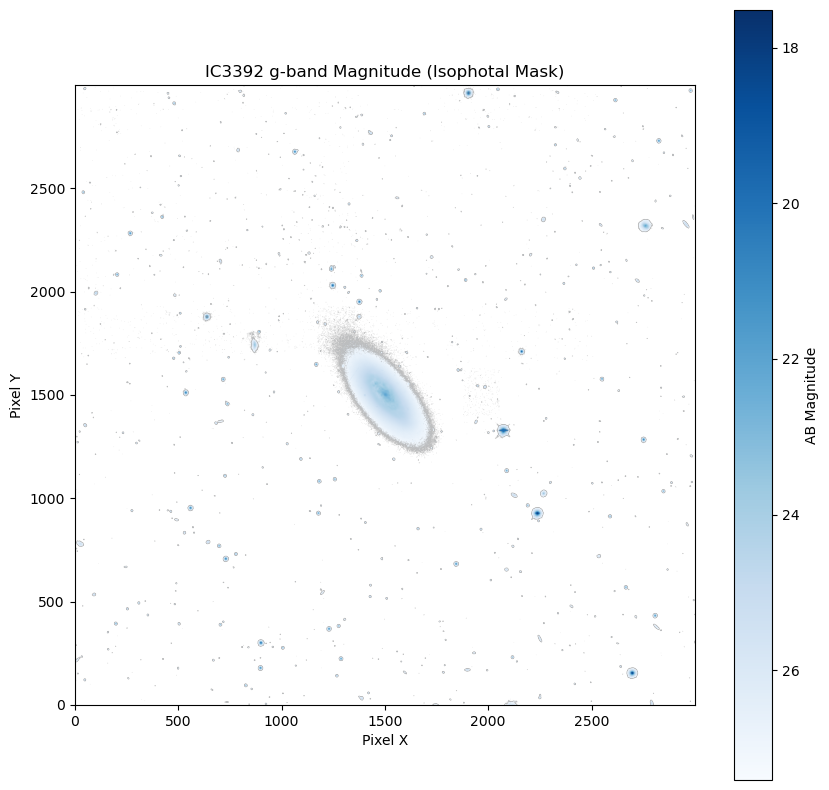

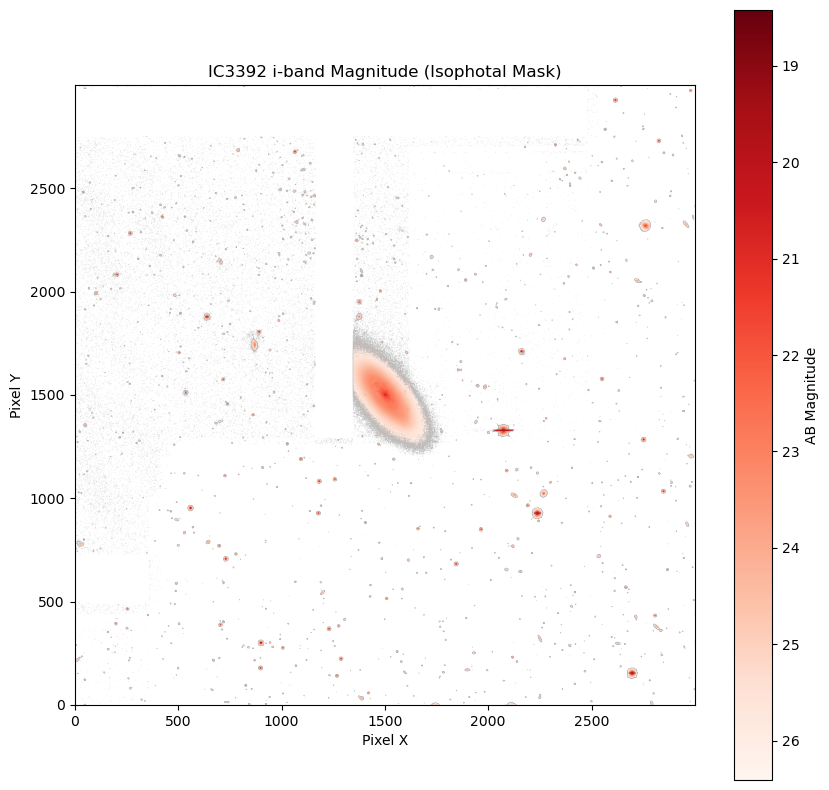

In [6]:
# g-band isophotal threshold: 24.5 mag/arcsec^2
# i-band isophotal threshold: 23.5 mag/arcsec^2
# with the pixel scale of 0.262 arcsec/pixel
g_band_limit = 24.5
i_band_limit = 23.5
pixel_scale = 0.262  # arcsec/pixel
# Convert mag/arcsec^2 to magnitude at each pixel
g_band_limit_pixel = g_band_limit - 2.5 * np.log10(pixel_scale**2)  
i_band_limit_pixel = i_band_limit - 2.5 * np.log10(pixel_scale**2)
print(f"g-band isophotal threshold in pixel scale: {g_band_limit_pixel:.2f} mag/pixel^2")
print(f"i-band isophotal threshold in pixel scale: {i_band_limit_pixel:.2f} mag/pixel^2")

# Create a mask for the g-band and i-band images in the isophotal limit
g_band_isophotal = np.where(
    g_band_magnitude < g_band_limit_pixel,
    g_band_magnitude,
    np.nan
)
i_band_isophotal = np.where(
    i_band_magnitude < i_band_limit_pixel,
    i_band_magnitude,
    np.nan
)

# Plot the isophotal mask for g-band
plt.figure(figsize=(10, 10))
plt.imshow(g_band_isophotal, cmap='Blues_r', origin='lower')
cbar = plt.colorbar(label='AB Magnitude')
cbar.ax.invert_yaxis()
plt.title(f"{object_name} g-band Magnitude (Isophotal Mask)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

# Plot the isophotal mask for i-band    
plt.figure(figsize=(10, 10))
plt.imshow(i_band_isophotal, cmap='Reds_r', origin='lower')
cbar = plt.colorbar(label='AB Magnitude')
cbar.ax.invert_yaxis()
plt.title(f"{object_name} i-band Magnitude (Isophotal Mask)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

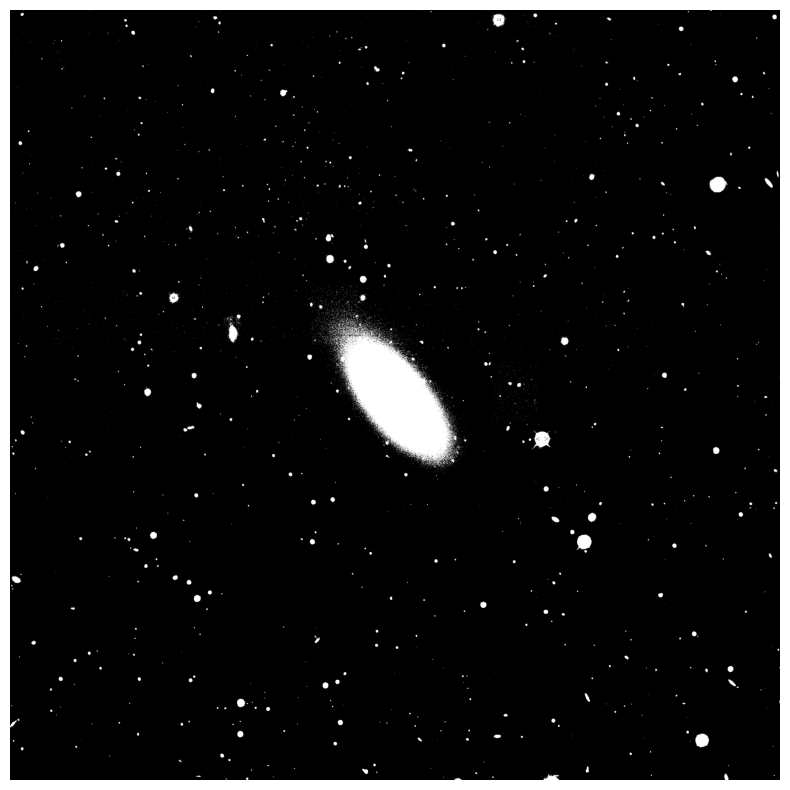

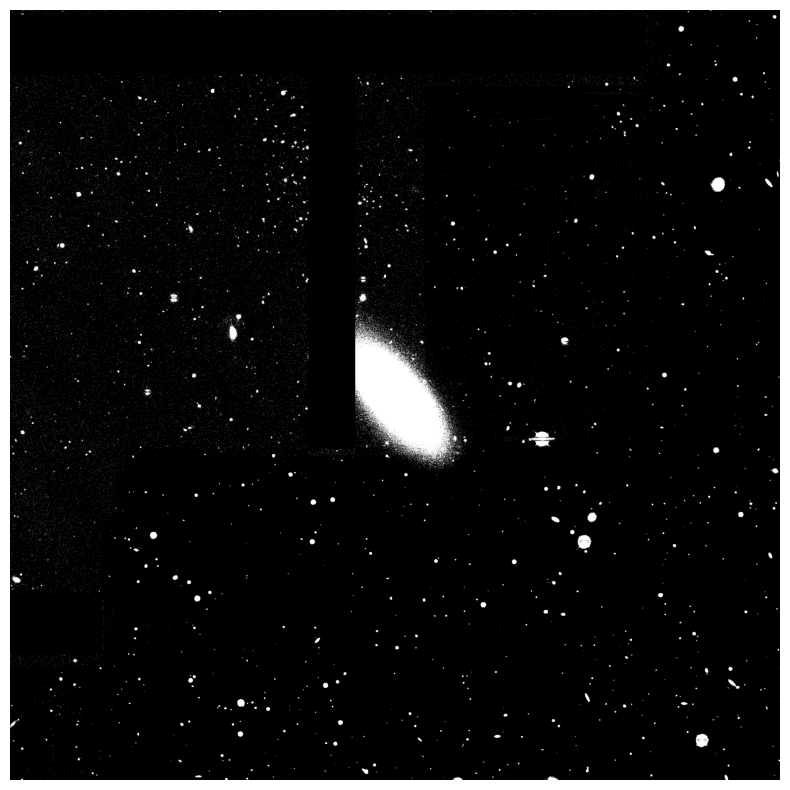

In [7]:
# build a binary mask: non-nan → 1 (white), nan → 0 (black)
binary_g = np.where(np.isnan(g_band_isophotal), 0, 1)
plt.figure(figsize=(10, 10))
plt.imshow(binary_g, cmap='gray', origin='lower', vmin=0, vmax=1)
plt.axis('off')
plt.show()

binary_i = np.where(np.isnan(i_band_isophotal), 0, 1)
plt.figure(figsize=(10, 10))
plt.imshow(binary_i, cmap='gray', origin='lower', vmin=0, vmax=1)
plt.axis('off')
plt.show()


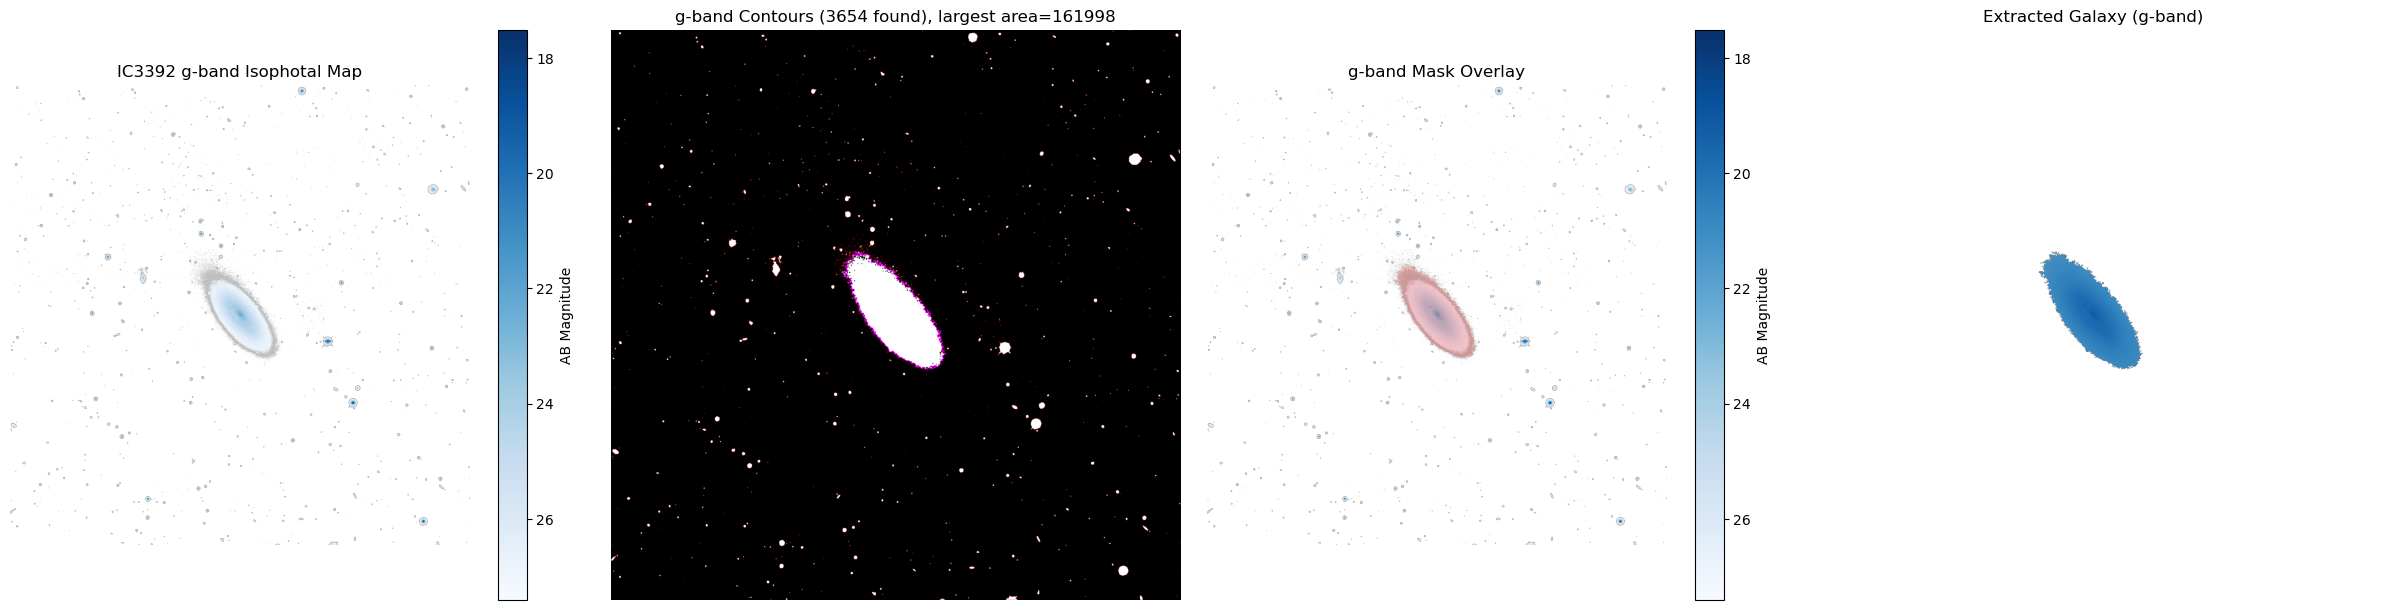

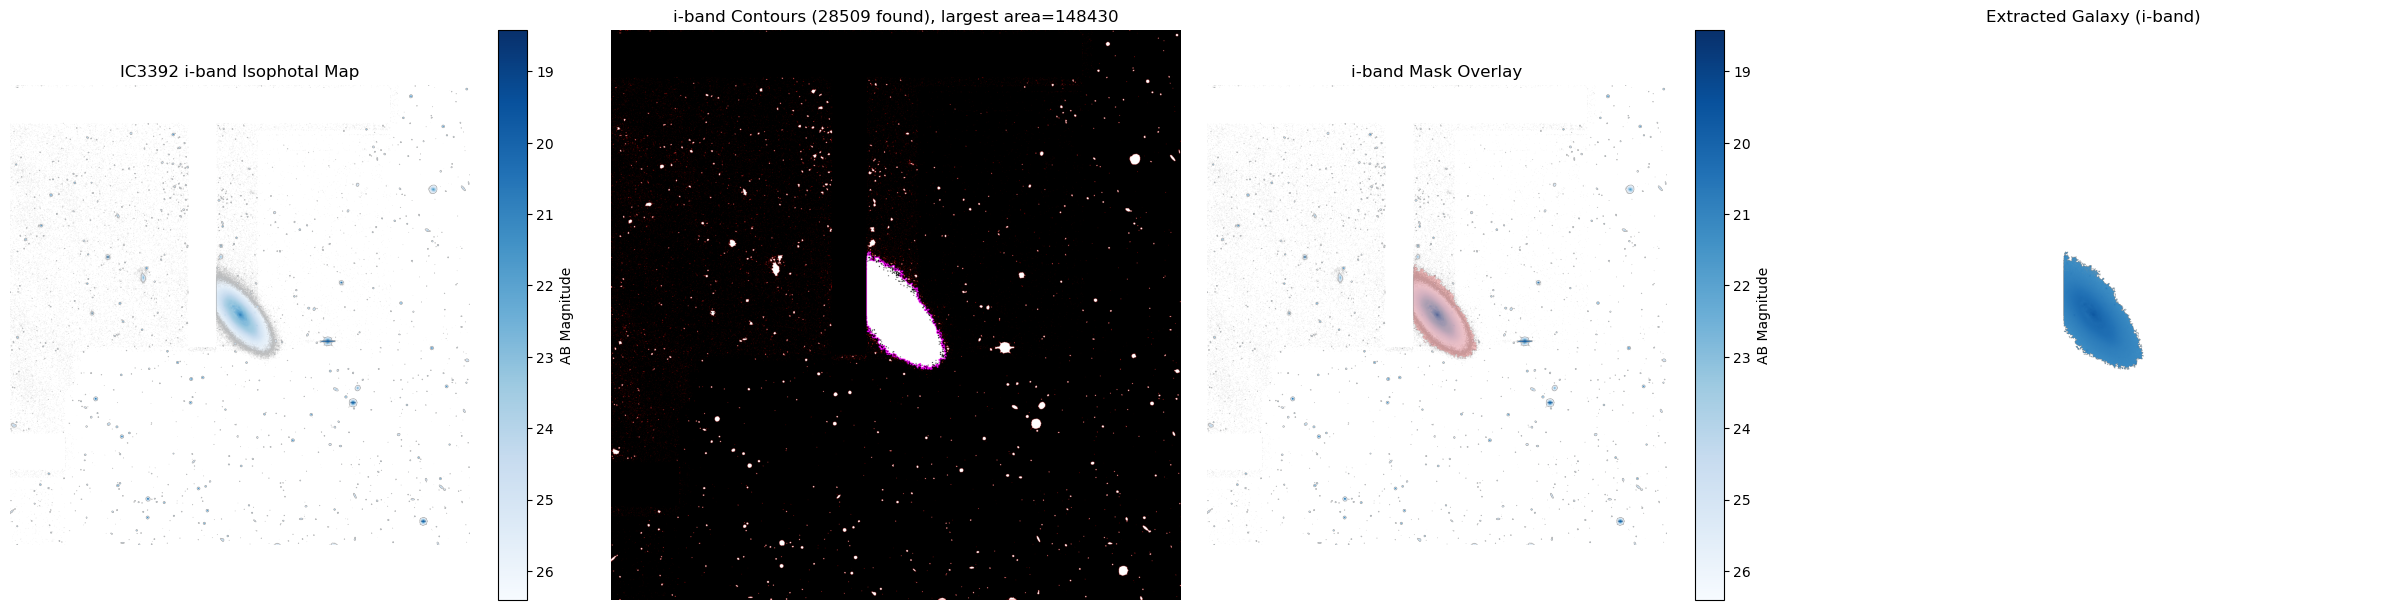

In [8]:
class GalaxyExtractor:
    def __init__(self, data, binary_mask, isophotal_map, band_name, kernel_size=5):
        """
        data:          2D numpy array from FITS
        binary_mask:   2D 0/1 mask
        isophotal_map: 2D array for overlay
        band_name:     'g' or 'i'
        kernel_size:   diameter of morphological element
        """
        self.data    = data
        self.mask01  = binary_mask
        self.iso     = isophotal_map
        self.name    = band_name
        self.kernel  = cv2.getStructuringElement(
            cv2.MORPH_ELLIPSE, (kernel_size, kernel_size)
        )

    def _compute_contours(self):
        m8 = (self.mask01 * 255).astype(np.uint8)
        # optional cleanup:
        # m8 = cv2.erode(m8, self.kernel, iterations=1)
        m8 = cv2.morphologyEx(m8, cv2.MORPH_CLOSE, self.kernel, iterations=1)
        cnts, _ = cv2.findContours(m8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        return m8, cnts

    def run(self):
        # Step 1: detect contours
        m8, cnts = self._compute_contours()
        vis = cv2.cvtColor(m8, cv2.COLOR_GRAY2BGR)
        largest = None
        if cnts:
            cv2.drawContours(vis, cnts, -1, (0,0,255), 1)
            largest = max(cnts, key=cv2.contourArea)
            cv2.drawContours(vis, [largest], -1, (255,0,255), 2)
        vis = cv2.flip(vis, 0)

        # Step 2: fill largest contour → mask + extract
        filled = np.zeros_like(m8)
        if largest is not None:
            cv2.drawContours(filled, [largest], -1, 255, thickness=-1)
        galaxy_mask = (filled > 0)
        galaxy = np.zeros_like(self.data)
        galaxy[galaxy_mask] = self.data[galaxy_mask]

        # Step 3: 1×4 plotting
        fig, axes = plt.subplots(1, 4, figsize=(24, 6))

        # Panel 1: isophotal map
        im0 = axes[0].imshow(self.iso, cmap='Blues_r', origin='lower')
        c0  = fig.colorbar(im0, ax=axes[0], label='AB Magnitude')
        c0.ax.invert_yaxis()
        axes[0].set_title(f"{object_name} {self.name}-band Isophotal Map")
        axes[0].set_xlabel("Pixel X");   axes[0].set_ylabel("Pixel Y")
        axes[0].axis('off')

        # Panel 2: contour overlay
        axes[1].imshow(vis[..., ::-1])  # BGR→RGB
        t2 = f"{self.name}-band Contours ({len(cnts)} found)"
        if largest is not None:
            t2 += f", largest area={cv2.contourArea(largest):.0f}"
        axes[1].set_title(t2)
        axes[1].axis('off')

        # Panel 3: mask overlay
        im2 = axes[2].imshow(self.iso, cmap='Blues_r', origin='lower')
        c2  = fig.colorbar(im2, ax=axes[2], label='AB Magnitude')
        c2.ax.invert_yaxis()
        axes[2].imshow(
            np.ma.masked_where(~galaxy_mask, galaxy_mask),
            cmap='autumn', alpha=0.2, origin='lower'
        )
        axes[2].set_title(f"{self.name}-band Mask Overlay")
        axes[2].axis('off')

        # Panel 4: extracted galaxy
        vmin = self.data[self.data > 0].min()
        vmax = self.data.max()
        axes[3].imshow(
            galaxy, cmap='Blues', origin='lower',
            norm=LogNorm(vmin=vmin, vmax=vmax)
        )
        axes[3].set_title(f"Extracted Galaxy ({self.name}-band)")
        axes[3].axis('off')

        plt.tight_layout()
        plt.show()

        # save for later
        self.galaxy_mask = galaxy_mask
        self.galaxy      = galaxy
        return galaxy_mask, galaxy

# --- Usage example for both g and i bands: ---
# instantiate and run
g_extractor = GalaxyExtractor(data[0], binary_g, g_band_isophotal, 'g')
galaxy_g_mask, galaxy_g = g_extractor.run()
i_extractor = GalaxyExtractor(data[0], binary_i, i_band_isophotal, 'i')
galaxy_i_mask, galaxy_i = i_extractor.run()

# build a mask of pixels that are not NaN in both isophotal maps
valid_both = (~np.isnan(g_band_isophotal)) & (~np.isnan(i_band_isophotal))

# combine: any pixel found in g _or_ i, but only where both maps are defined
galaxy_combined_mask = (galaxy_g_mask | galaxy_i_mask) & valid_both

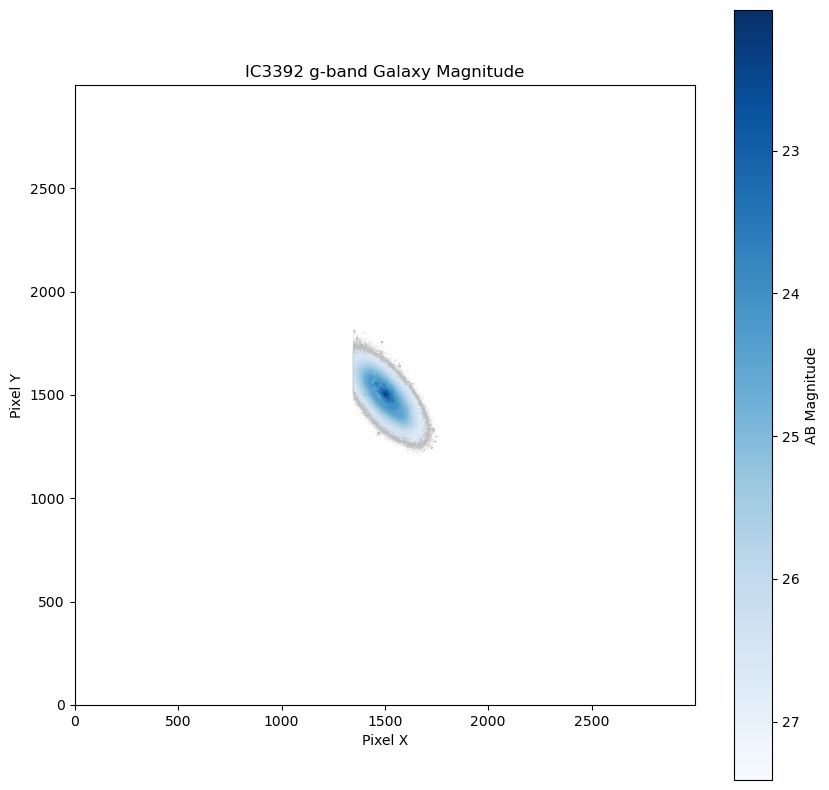

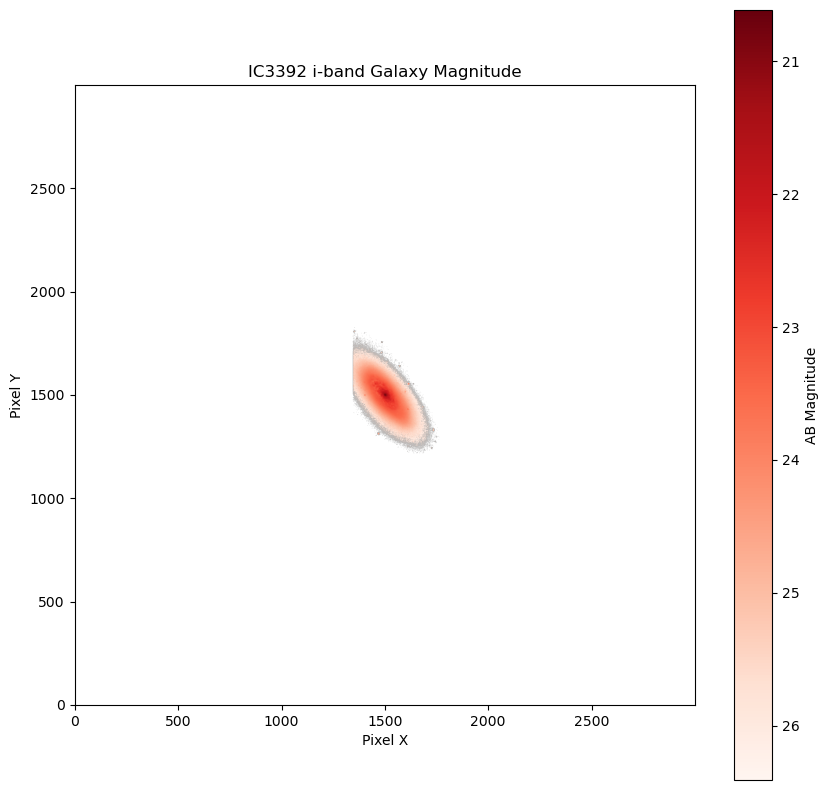

Total g-band flux: 8877.3193359375 nanomaggies
Total i-band flux: 22469.751953125 nanomaggies
Total g-band magnitude: 12.629
Total i-band magnitude: 11.621
Photometric g-band magnitude: 12.554
Photometric i-band magnitude: 11.579


In [9]:
# Extract galaxy magnitude in g-band and i-band
g_band_galaxy_magnitude = np.where(galaxy_combined_mask, g_band_magnitude, np.nan)
i_band_galaxy_magnitude = np.where(galaxy_combined_mask, i_band_magnitude, np.nan)

# Plot the extracted galaxy magnitude in g-band
plt.figure(figsize=(10, 10))
plt.imshow(g_band_galaxy_magnitude, cmap='Blues_r', origin='lower')
cbar = plt.colorbar(label='AB Magnitude')
cbar.ax.invert_yaxis()
plt.title(f"{object_name} g-band Galaxy Magnitude")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()
# Plot the extracted galaxy magnitude in i-band
plt.figure(figsize=(10, 10))
plt.imshow(i_band_galaxy_magnitude, cmap='Reds_r', origin='lower')
cbar = plt.colorbar(label='AB Magnitude')
cbar.ax.invert_yaxis()
plt.title(f"{object_name} i-band Galaxy Magnitude")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

# Extract the galaxy flux in g-band and i-band
g_band_galaxy_flux = np.where(galaxy_combined_mask, g_band_flux_corrected, np.nan)
i_band_galaxy_flux = np.where(galaxy_combined_mask, i_band_flux_corrected, np.nan)

# Calculate the total flux in g-band and i-band
g_band_galaxy_total_flux = np.nansum(g_band_galaxy_flux)
i_band_galaxy_total_flux = np.nansum(i_band_galaxy_flux)
print(f"Total g-band flux: {g_band_galaxy_total_flux} nanomaggies")
print(f"Total i-band flux: {i_band_galaxy_total_flux} nanomaggies")
# Calculate the total magnitude in g-band and i-band    
g_band_galaxy_total_magnitude = 22.5 - 2.5 * np.log10(g_band_galaxy_total_flux)
i_band_galaxy_total_magnitude = 22.5 - 2.5 * np.log10(i_band_galaxy_total_flux)
print(f"Total g-band magnitude: {g_band_galaxy_total_magnitude:.3f}")
print(f"Total i-band magnitude: {i_band_galaxy_total_magnitude:.3f}")

# Calculate the total photometric flux in g-band and i-band
g_band_photometric_flux = np.where(galaxy_g_mask, g_band_flux_corrected, np.nan)
i_band_photometric_flux = np.where(galaxy_i_mask, i_band_flux_corrected, np.nan)
# Calculate the total photometric magitude in g-band and i-band
g_band_photometric_magnitude = 22.5 - 2.5 * np.log10(np.nansum(g_band_photometric_flux))
i_band_photometric_magnitude = 22.5 - 2.5 * np.log10(np.nansum(i_band_photometric_flux))
print(f"Photometric g-band magnitude: {g_band_photometric_magnitude:.3f}")
print(f"Photometric i-band magnitude: {i_band_photometric_magnitude:.3f}")

In [10]:
# Universal distance lookup (in Mpc, Corteste et al. 2012)
distance_lookup = {
    "IC3392": 17.00,
    "NGC4383": 17.00, 
    "NGC4501": 17.00, 
    "NGC4192": 17.00, 
}
# fallback to 16.5 Mpc (distance of Virgo, Mei et al. 2007) if object_name not in the dict
distance_mpc = distance_lookup.get(object_name, 16.50)
distance_pc = distance_mpc * 1e6
DM = 5 * np.log10(distance_pc / 10.0)

# For NGC4383 in Cortese et al. 2012, the distance is 17.0 Mpc, g-band is 12.392, i-band is 11.654, override the values for testing
# g_band_galaxy_total_magnitude = 12.392
# i_band_galaxy_total_magnitude = 11.654

# Compute absolute magnitude in g-band
g_band_galaxy_Magnitude = g_band_galaxy_magnitude - DM
g_band_galaxy_total_Magnitude = g_band_galaxy_total_magnitude - DM
# Compute absolute magnitude in i-band
i_band_galaxy_Magnitude = i_band_galaxy_magnitude - DM
i_band_galaxy_total_Magnitude = i_band_galaxy_total_magnitude - DM
print(f"Total g-band magnitude: {g_band_galaxy_total_magnitude:.3f}")
print(f"Total i-band magnitude: {i_band_galaxy_total_magnitude:.3f}")
print(f"Total absolute g-band Magnitude: {g_band_galaxy_total_Magnitude:.2f}")
print(f"Total absolute i-band Magnitude: {i_band_galaxy_total_Magnitude:.2f}")

# Compute g-i color
g_minus_i_galaxy_magnitude = g_band_galaxy_magnitude - i_band_galaxy_magnitude
g_minus_i_galaxy_total_magnitude = g_band_galaxy_total_magnitude - i_band_galaxy_total_magnitude

# Estimate log(M_*/M_\odot) using the g-i color (Taylot et al. 2011)
# log(M_*/M_\odot) = 1.15 + 0.7 * (g-i) - 0.4 * M_i
log_stellar_mass = 1.15 + 0.7 * g_minus_i_galaxy_magnitude - 0.4 * i_band_galaxy_Magnitude
stellar_mass = 10**log_stellar_mass
stellar_mass_sum = np.nansum(stellar_mass)
log_stellar_mass_sum = np.log10(stellar_mass_sum)
log_stellar_mass_total = 1.15 + 0.7 * g_minus_i_galaxy_total_magnitude - 0.4 * i_band_galaxy_total_Magnitude
stellar_mass_total = 10**log_stellar_mass_total

# Estimate log(M_*/M_\odot) using the g-i color in Corteste et al. 2012, adopted from Zibetti et al. 2009
# log(M_*/M_\odot) = 0.869 + 1.032 * (g-i) - 0.4 * M_i
log_stellar_mass_toatl_luca = 0.869 + 1.032 * g_minus_i_galaxy_total_magnitude - 0.4 * i_band_galaxy_total_Magnitude
stellar_mass_toatl_luca = 10**log_stellar_mass_toatl_luca
print(f"Stellar mass sum up in {object_name}: {stellar_mass_sum:.2e} M_sun or log (M_*/M_sun) = {log_stellar_mass_sum:.2f}")
print(f"Stellar mass total in {object_name}: {stellar_mass_total:.2e} M_sun or log (M_*/M_sun) = {log_stellar_mass_total:.2f}")
print(f"Stellar mass total in {object_name} (Corteste et al. 2012): {stellar_mass_toatl_luca:.2e} M_sun or log (M_*/M_sun) = {log_stellar_mass_toatl_luca:.2f}")

Total g-band magnitude: 12.629
Total i-band magnitude: 11.621
Total absolute g-band Magnitude: -18.52
Total absolute i-band Magnitude: -19.53
Stellar mass sum up in IC3392: 4.91e+09 M_sun or log (M_*/M_sun) = 9.69
Stellar mass total in IC3392: 4.66e+09 M_sun or log (M_*/M_sun) = 9.67
Stellar mass total in IC3392 (Corteste et al. 2012): 5.27e+09 M_sun or log (M_*/M_sun) = 9.72


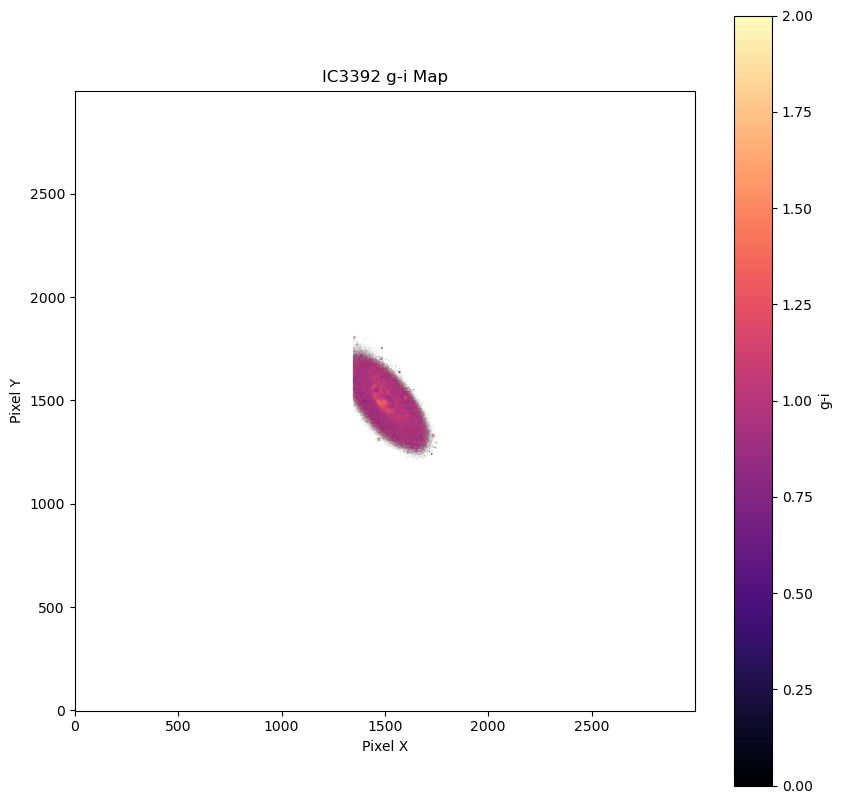

In [11]:
# Visualize g-i color map
plt.figure(figsize=(10, 10))
plt.imshow(g_minus_i_galaxy_magnitude, origin='lower', cmap='magma', vmin=0, vmax=2)
cbar = plt.colorbar(label='g-i')
plt.title(f"{object_name} g-i Map")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

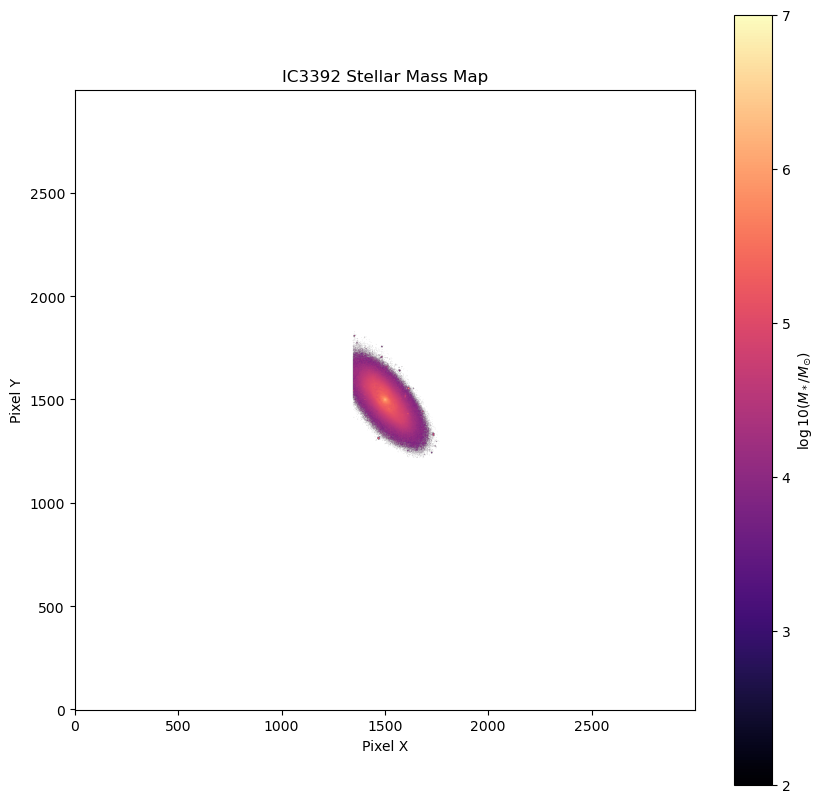

In [12]:
# Visualize the stellar mass distribution
plt.figure(figsize=(10, 10))
plt.imshow(log_stellar_mass, origin='lower', cmap='magma', vmin=2, vmax=7)
cbar = plt.colorbar(label=r'$\log{10}(M_*/M_{\odot})$')
plt.title(f"{object_name} Stellar Mass Map")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

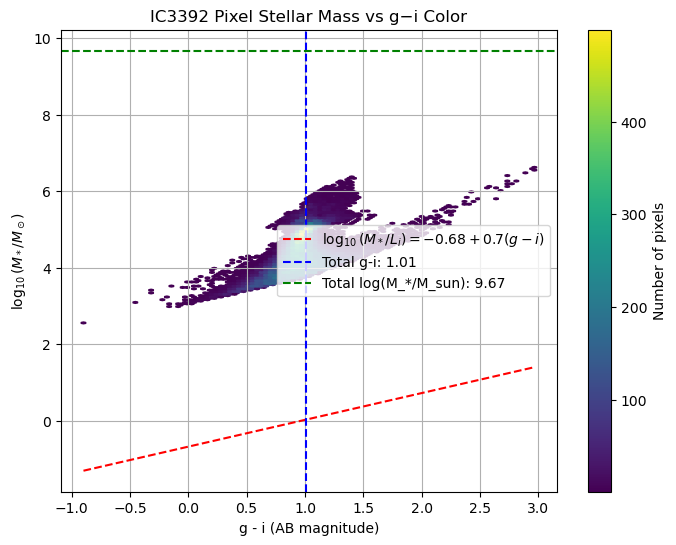

In [13]:
# Plot log(M_*/M_sun) vs g−i color, color‐coded by pixel density
mask = (~np.isnan(g_minus_i_galaxy_magnitude)) & (~np.isnan(log_stellar_mass))
x = g_minus_i_galaxy_magnitude[mask]
y = log_stellar_mass[mask]

plt.figure(figsize=(8, 6))
hb = plt.hexbin(x, y, gridsize=100, cmap='viridis', mincnt=1)
cbar = plt.colorbar(hb)
cbar.set_label('Number of pixels')

plt.xlabel('g - i (AB magnitude)')
plt.ylabel(r'$\log_{10}(M_*/M_\odot)$')
plt.title(f'{object_name} Pixel Stellar Mass vs g−i Color')

# Plot the log(M_*/L_i) vs g−i color line: -0.68+0.7*(g-i)
x_line = np.linspace(np.min(x), np.max(x), 100)
y_line = -0.68 + 0.7 * x_line
plt.plot(x_line, y_line, color='red', linestyle='--', label=r'$\log_{10}(M_*/L_i) = -0.68 + 0.7(g-i)$')
plt.legend()
plt.grid()

# Plot the total g -i color and log(M_*/M_sun) values as vertical and horizontal lines
plt.axvline(g_minus_i_galaxy_total_magnitude, color='blue', linestyle='--', label=f'Total g-i: {g_minus_i_galaxy_total_magnitude:.2f}')
plt.axhline(log_stellar_mass_total, color='green', linestyle='--', label=f'Total log(M_*/M_sun): {log_stellar_mass_total:.2f}')
plt.legend()
plt.show()


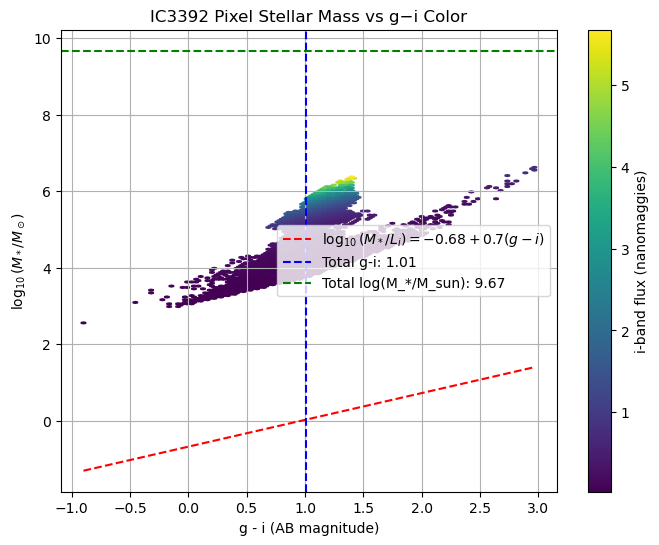

In [14]:
# Plot log(M_*/M_sun) vs g−i color, color‐coded by i band flux
mask = (~np.isnan(g_minus_i_galaxy_magnitude)) & (~np.isnan(log_stellar_mass))
x = g_minus_i_galaxy_magnitude[mask]
y = log_stellar_mass[mask]

plt.figure(figsize=(8, 6))
hb = plt.hexbin(x, y, C=i_band_galaxy_flux[mask], gridsize=100, cmap='viridis', mincnt=1)
cbar = plt.colorbar(hb)
cbar.set_label('i-band flux (nanomaggies)')

plt.xlabel('g - i (AB magnitude)')
plt.ylabel(r'$\log_{10}(M_*/M_\odot)$')
plt.title(f'{object_name} Pixel Stellar Mass vs g−i Color')

# Plot the log(M_*/L_i) vs g−i color line: -0.68+0.7*(g-i)
x_line = np.linspace(np.min(x), np.max(x), 100)
y_line = -0.68 + 0.7 * x_line
plt.plot(x_line, y_line, color='red', linestyle='--', label=r'$\log_{10}(M_*/L_i) = -0.68 + 0.7(g-i)$')
plt.legend()
plt.grid()

# Plot the total g -i color and log(M_*/M_sun) values as vertical and horizontal lines
plt.axvline(g_minus_i_galaxy_total_magnitude, color='blue', linestyle='--', label=f'Total g-i: {g_minus_i_galaxy_total_magnitude:.2f}')
plt.axhline(log_stellar_mass_total, color='green', linestyle='--', label=f'Total log(M_*/M_sun): {log_stellar_mass_total:.2f}')
plt.legend()
plt.show()

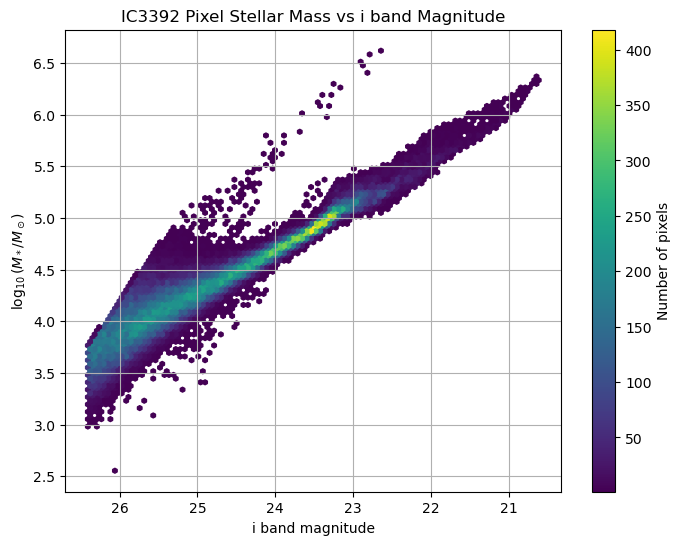

In [15]:
# Plot log(M_*/M_sun) vs i band magnitude
plt.figure(figsize=(8, 6))
plt.hexbin(i_band_galaxy_magnitude[mask], log_stellar_mass[mask], gridsize=100, cmap='viridis', mincnt=1)
plt.colorbar(label='Number of pixels')
plt.xlabel('i band magnitude')
plt.ylabel(r'$\log_{10}(M_*/M_\odot)$')
# Inver the x-axis for magnitude
plt.gca().invert_xaxis()
plt.title(f'{object_name} Pixel Stellar Mass vs i band Magnitude')
plt.grid()
plt.show()

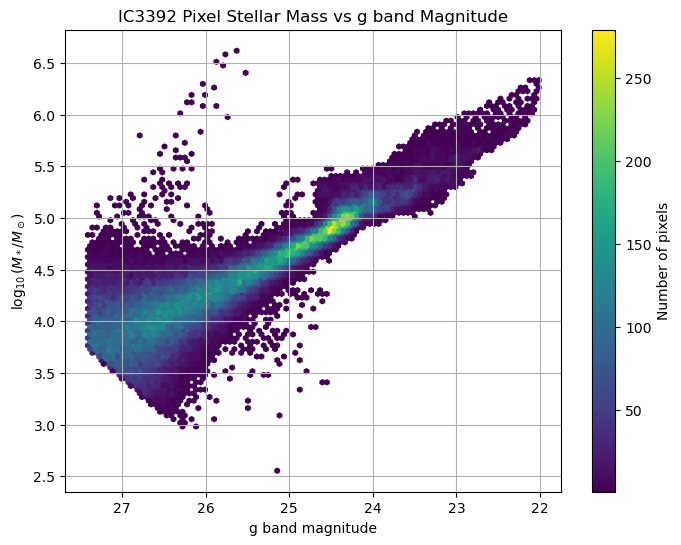

In [16]:
# Plot log(M_*/M_sun) vs g band magnitude
plt.figure(figsize=(8, 6))
plt.hexbin(g_band_galaxy_magnitude[mask], log_stellar_mass[mask], gridsize=100, cmap='viridis', mincnt=1)
plt.colorbar(label='Number of pixels')
plt.xlabel('g band magnitude')
plt.ylabel(r'$\log_{10}(M_*/M_\odot)$')
# Inver the x-axis for magnitude
plt.gca().invert_xaxis()
plt.title(f'{object_name} Pixel Stellar Mass vs g band Magnitude')
plt.grid()
plt.show()

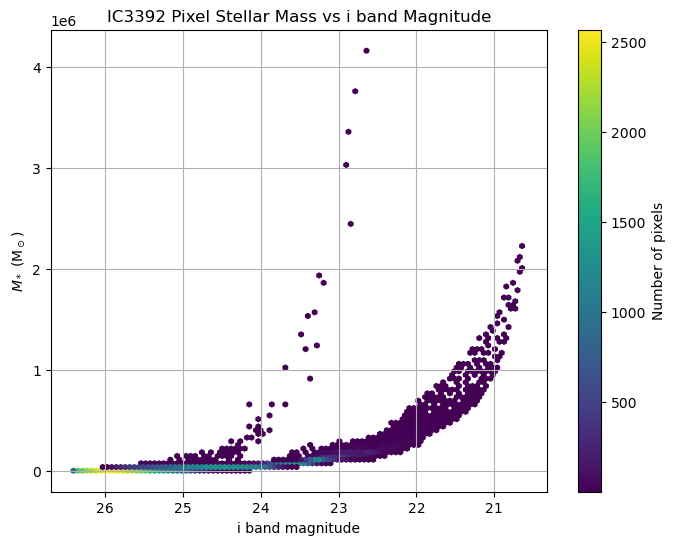

In [17]:
# Plot M_* vs i band magnitude
plt.figure(figsize=(8, 6))
plt.hexbin(i_band_galaxy_magnitude[mask], stellar_mass[mask], gridsize=100, cmap='viridis', mincnt=1)
plt.colorbar(label='Number of pixels')
plt.xlabel('i band magnitude')
plt.ylabel(r'$M_*$ (M$_\odot$)')
# Inver the x-axis for magnitude
plt.gca().invert_xaxis()
plt.title(f'{object_name} Pixel Stellar Mass vs i band Magnitude')
plt.grid()
plt.show()

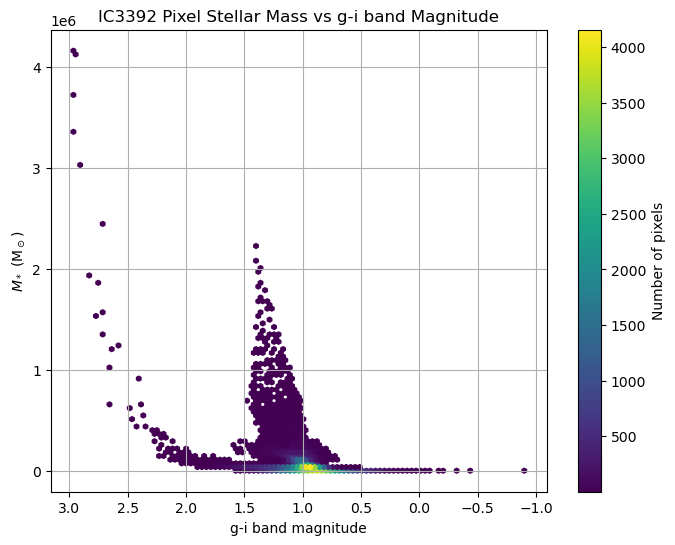

In [18]:
# Plot M_* vs g-i band magnitude
plt.figure(figsize=(8, 6))
plt.hexbin(g_minus_i_galaxy_magnitude[mask], stellar_mass[mask], gridsize=100, cmap='viridis', mincnt=1)
plt.colorbar(label='Number of pixels')
plt.xlabel('g-i band magnitude')
plt.ylabel(r'$M_*$ (M$_\odot$)')
# Inver the x-axis for magnitude
plt.gca().invert_xaxis()
plt.title(f'{object_name} Pixel Stellar Mass vs g-i band Magnitude')
plt.grid()
plt.show()

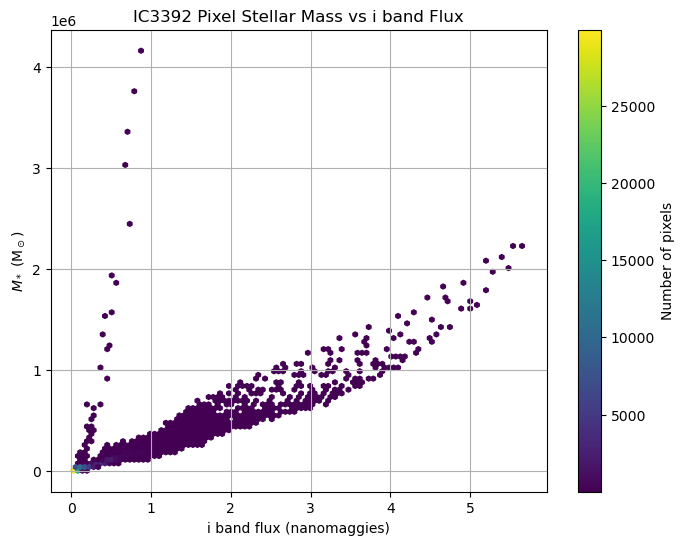

In [19]:
# Plot M_* vs i band flux
plt.figure(figsize=(8, 6))
plt.hexbin(i_band_galaxy_flux[mask], stellar_mass[mask], gridsize=100, cmap='viridis', mincnt=1)
plt.colorbar(label='Number of pixels')
plt.xlabel('i band flux (nanomaggies)')
plt.ylabel(r'$M_*$ (M$_\odot$)')
plt.title(f'{object_name} Pixel Stellar Mass vs i band Flux')
plt.grid()
plt.show()

Ellipse center = (1509.18, 1488.07)
Major axis = 567.56 px, Minor axis = 252.90 px, Angle = 37.51°
Major axis = 148.70 arcsec
Major axis = 2.48 arcmin
Major axis = 7.21e-04 rad
Major axis = 12.26 kpc
Minor axis = 66.26 arcsec
Minor axis = 1.10 arcmin
Minor axis = 3.21e-04 rad
Minor axis = 5.46 kpc


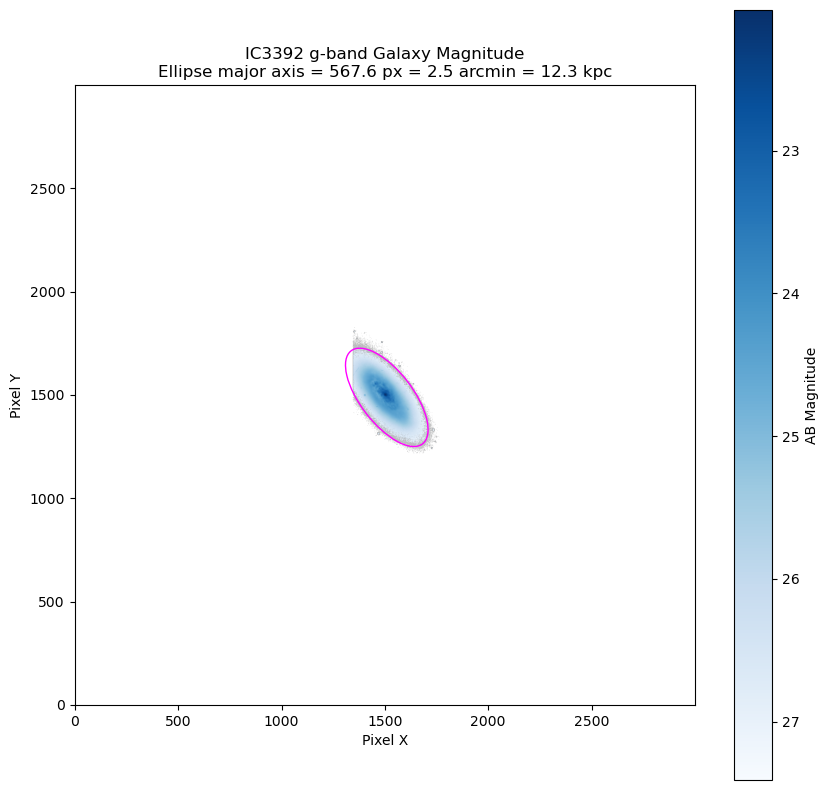

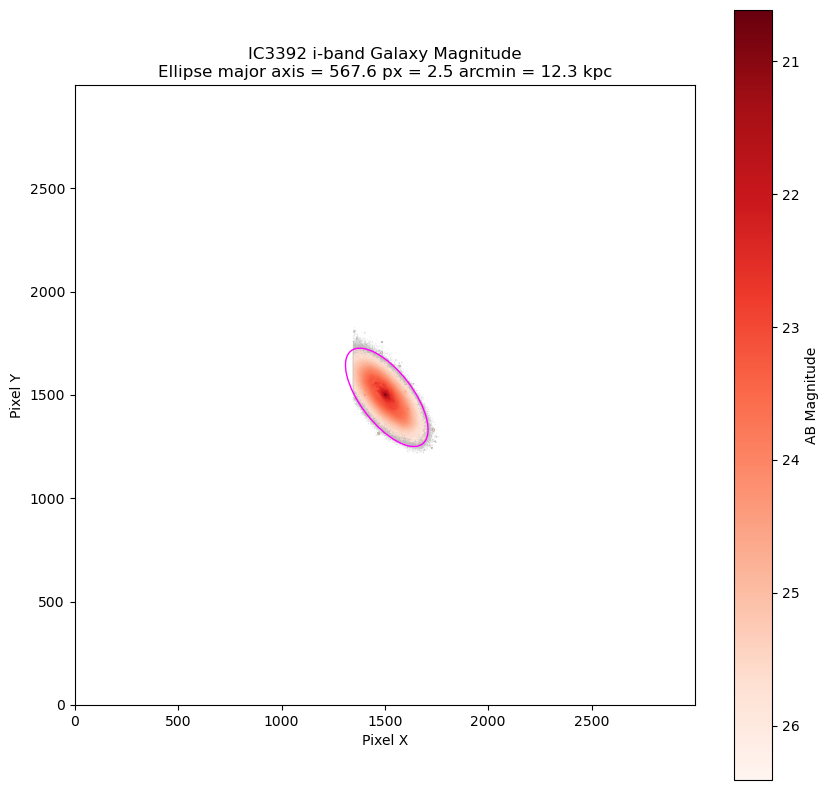

In [20]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.colors import LogNorm

# 1) Prepare mask and find contours
mask_uint8 = (galaxy_combined_mask.astype(np.uint8) * 255)
cnts, _    = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
if not cnts:
    raise RuntimeError("No contours found in galaxy_combined_mask.")

# pick the largest contour by area
cnt = max(cnts, key=cv2.contourArea)
if len(cnt) < 5:
    raise RuntimeError("Need at least 5 points to fit an ellipse.")

# 2) Fit ellipse
#    fitEllipse returns ((cx, cy), (major_axis, minor_axis), angle_deg)
(cx, cy), (MA, ma), angle = cv2.fitEllipse(cnt)
# ensure we have (major, minor) in the right order
major_axis = max(MA, ma)
minor_axis = min(MA, ma)


print(f"Ellipse center = ({cx:.2f}, {cy:.2f})")
print(f"Major axis = {major_axis:.2f} px, Minor axis = {minor_axis:.2f} px, Angle = {angle:.2f}°")

# Convert major axis to isophotal radius, recall that the pixel scale is 0.262 arcsec/pixel
major_axis_arcsec = major_axis * pixel_scale
print(f"Major axis = {major_axis_arcsec:.2f} arcsec")
major_axis_arcmin = major_axis_arcsec / 60
print(f"Major axis = {major_axis_arcmin:.2f} arcmin")
major_axis_rad = major_axis_arcsec * np.pi / 180 / 3600
print(f"Major axis = {major_axis_rad:.2e} rad")
major_axis_kpc = major_axis_rad * distance_mpc * 1e3
print(f"Major axis = {major_axis_kpc:.2f} kpc")

# Convert minor axis to isophotal radius, recall that the pixel scale is 0.262 arcsec/pixel
minor_axis_arcsec = minor_axis * pixel_scale
print(f"Minor axis = {minor_axis_arcsec:.2f} arcsec")
minor_axis_arcmin = minor_axis_arcsec / 60
print(f"Minor axis = {minor_axis_arcmin:.2f} arcmin")
minor_axis_rad = minor_axis_arcsec * np.pi / 180 / 3600
print(f"Minor axis = {minor_axis_rad:.2e} rad")
minor_axis_kpc = minor_axis_rad * distance_mpc * 1e3
print(f"Minor axis = {minor_axis_kpc:.2f} kpc")


# make a matplotlib Ellipse patch (width=MA, height=ma)
ellipse_patch = Ellipse(
    xy=(cx, cy),
    width=minor_axis,    # horizontal diameter
    height=major_axis,   # vertical diameter
    angle=angle,         # keyword-only per Matplotlib API
    edgecolor='magenta',
    facecolor='none',
    linewidth=1
)

# 3) Overlay on the g-band magnitude map
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(g_band_galaxy_magnitude, cmap='Blues_r', origin='lower')
cbar = plt.colorbar(im, ax=ax, label='AB Magnitude')
cbar.ax.invert_yaxis()
ax.add_patch(ellipse_patch)
ax.set_title(f"{object_name} g-band Galaxy Magnitude\n"
             f"Ellipse major axis = {major_axis:.1f} px = {major_axis_arcmin:.1f} arcmin = {major_axis_kpc:.1f} kpc")
ax.set_xlabel("Pixel X")
ax.set_ylabel("Pixel Y")
plt.show()

# 4) Overlay on the i-band magnitude map
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(i_band_galaxy_magnitude, cmap='Reds_r', origin='lower')
cbar = plt.colorbar(im, ax=ax, label='AB Magnitude')
cbar.ax.invert_yaxis()

ellipse = Ellipse(
    xy=(cx, cy),
    width=minor_axis,
    height=major_axis,
    angle=angle,
    edgecolor='magenta',
    facecolor='none',
    linewidth=1
)
ax.add_patch(ellipse)

ax.set_title(f"{object_name} i-band Galaxy Magnitude\n"
             f"Ellipse major axis = {major_axis:.1f} px = {major_axis_arcmin:.1f} arcmin = {major_axis_kpc:.1f} kpc")
ax.set_xlabel("Pixel X")
ax.set_ylabel("Pixel Y")
plt.show()



Original semi-axes: a=283.8px, b=126.5px
New semi-axes:      a2=364.0px, b2=173.0px
Ellipse orig major = 567.6px = 148.7" = 2.478′ = 12.26 kpc
Ellipse encl major = 727.9px = 190.7" = 3.179′ = 15.72 kpc


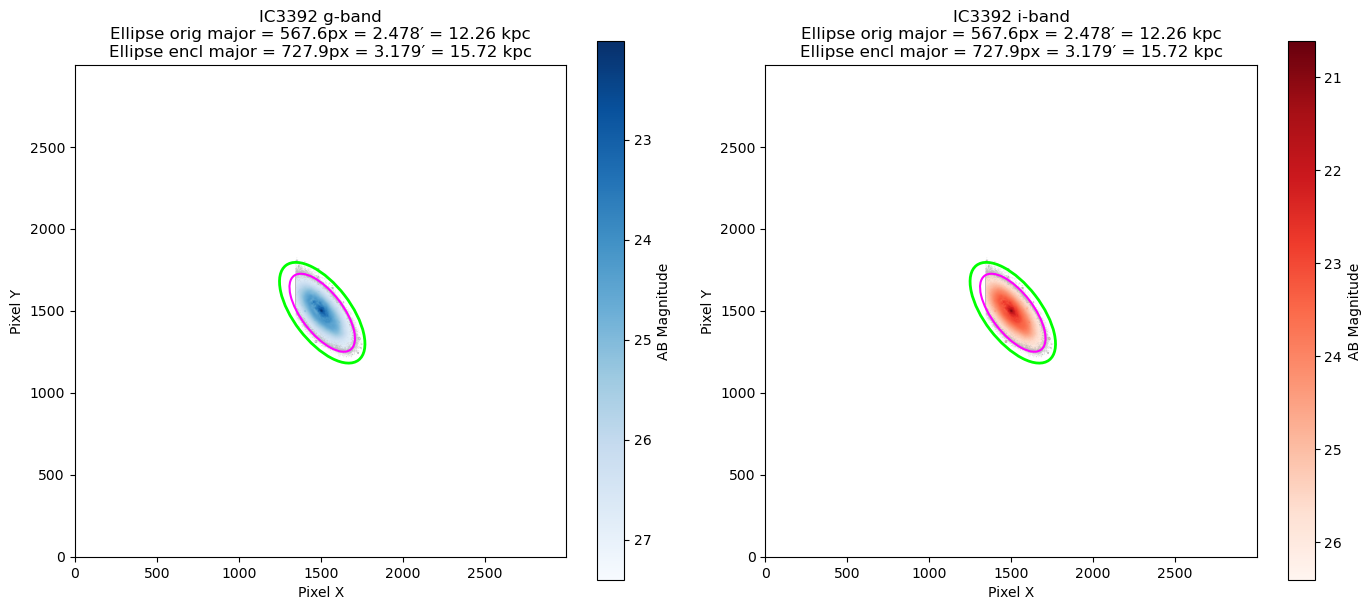

In [21]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# --- (same inputs as before) ---
# galaxy_combined_mask, g_band_galaxy_magnitude, i_band_galaxy_magnitude
# pixel_scale, distance_mpc, object_name

# 1) Largest contour + original fit
mask_u8 = (galaxy_combined_mask.astype(np.uint8) * 255)
cnts, _ = cv2.findContours(mask_u8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cnt = max(cnts, key=cv2.contourArea)

(cx, cy), (w, h), angle = cv2.fitEllipse(cnt)
a = h/2.0  # semi-major
b = w/2.0  # semi-minor

# 2) Convex hull over ALL valid pixels
ys, xs = np.nonzero(galaxy_combined_mask)
pts_all = np.vstack([xs, ys]).T.astype(np.float32)
hull_all = cv2.convexHull(pts_all.reshape(-1,1,2), returnPoints=True).reshape(-1,2)

# 3) Rotate hull into ellipse frame
θ = np.deg2rad(angle)
R = np.array([[ np.cos(θ), -np.sin(θ)],
              [ np.sin(θ),  np.cos(θ)]])
# subtract center and project
V = hull_all - np.array([cx, cy])
rot = (R.T @ V.T).T  # shape (N,2)

# compute new semi-axes as the max absolute coords
a2 = np.max(np.abs(rot[:,1]))
b2 = np.max(np.abs(rot[:,0]))

print(f"Original semi-axes: a={a:.1f}px, b={b:.1f}px")
print(f"New semi-axes:      a2={a2:.1f}px, b2={b2:.1f}px")

# 4) Full-axes + unit conversions
orig_major_px = 2*a
encl_major_px = 2*a2

def conv(px):
    arcsec = px * pixel_scale
    arcmin = arcsec / 60
    rad    = arcsec * np.pi/(180*3600)
    kpc    = rad * distance_mpc * 1e3
    return arcsec, arcmin, rad, kpc

om_as, om_am, om_rad, om_kpc = conv(orig_major_px)
em_as, em_am, em_rad, em_kpc = conv(encl_major_px)

print(f"Ellipse orig major = {orig_major_px:.1f}px = {om_as:.1f}\" = {om_am:.3f}′ = {om_kpc:.2f} kpc")
print(f"Ellipse encl major = {encl_major_px:.1f}px = {em_as:.1f}\" = {em_am:.3f}′ = {em_kpc:.2f} kpc")

# 5) Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for ax, img, cmap, band in zip(
    axes,
    [g_band_galaxy_magnitude, i_band_galaxy_magnitude],
    ['Blues_r','Reds_r'],
    ['g-band','i-band']
):
    im = ax.imshow(img, cmap=cmap, origin='lower')
    cbar = plt.colorbar(im, ax=ax, label='AB Magnitude')
    cbar.ax.invert_yaxis()

    # original
    ax.add_patch(Ellipse(
        xy=(cx, cy), width=2*b, height=2*a, angle=angle,
        edgecolor='magenta', facecolor='none', linewidth=1.5
    ))
    # new enclosing
    ax.add_patch(Ellipse(
        xy=(cx, cy), width=2*b2, height=2*a2, angle=angle,
        edgecolor='lime', facecolor='none', linewidth=2
    ))

    title = (
        f"{object_name} {band}\n"
        f"Ellipse orig major = {orig_major_px:.1f}px = {om_am:.3f}′ = {om_kpc:.2f} kpc\n"
        f"Ellipse encl major = {encl_major_px:.1f}px = {em_am:.3f}′ = {em_kpc:.2f} kpc"
    )
    ax.set_title(title)
    ax.set_xlabel("Pixel X")
    ax.set_ylabel("Pixel Y")

plt.tight_layout()
plt.show()


Binned mass @ 100×100 = 2.52e+09 > prev 4.76e+09 or < true total 4.66e+09
→ fallback to true total (log10 M⊙) = 9.67


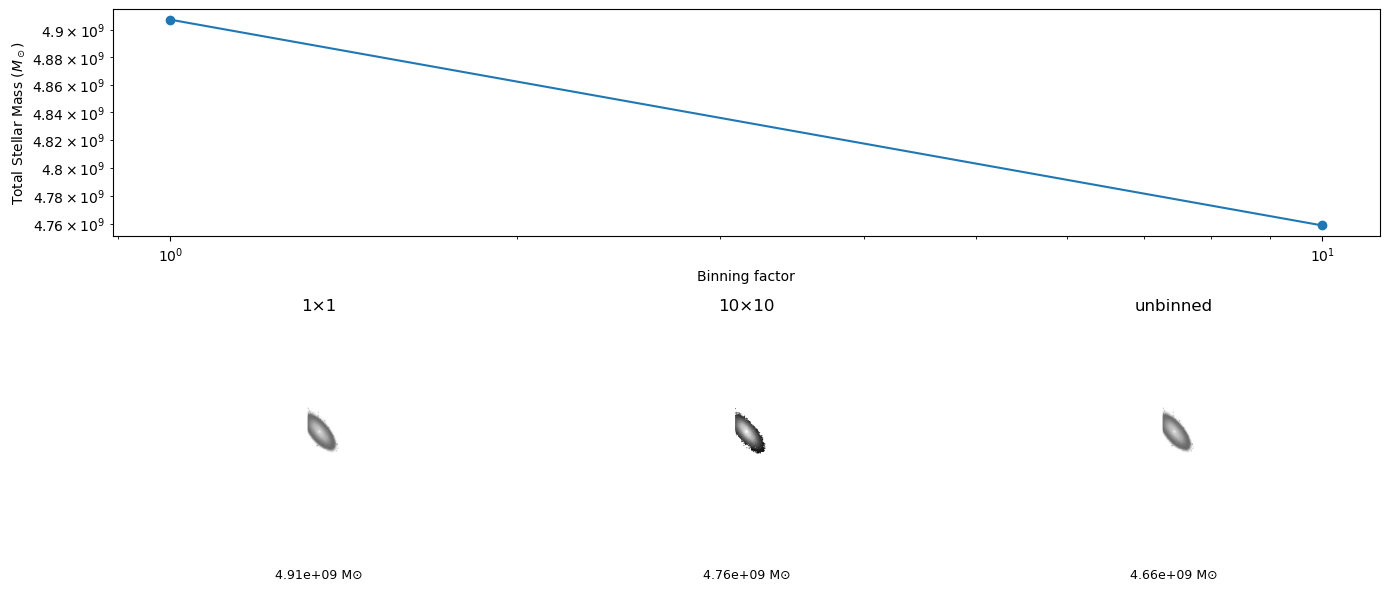

In [22]:
# clear previous results
mass_totals    = []
binned_maps    = []
prev_total     = None

# bin_scales = [1, 4, 16, 64, 256, 512, 1024]
bin_scales = [1, 10, 100, 1000]  

def bin_image(image, bin_factor):
    # crop so height and width are multiples of bin_factor
    h, w = image.shape[:2]
    h2 = h - (h % bin_factor)
    w2 = w - (w % bin_factor)
    img = image[:h2, :w2]
    # reshape into blocks and sum
    return img.reshape(h2//bin_factor, bin_factor, w2//bin_factor, bin_factor).sum(axis=(1,3))

for bs in bin_scales:
    # re‐use your bin_image() function
    mask_b   = bin_image(galaxy_combined_mask.astype(int), bs) > 0
    gflux_b  = bin_image(g_band_flux_corrected, bs)
    iflux_b  = bin_image(i_band_flux_corrected, bs)
    valid    = mask_b & (gflux_b > 0) & (iflux_b > 0)

    # per‐bin magnitudes
    gmag_b = np.full_like(gflux_b, np.nan, dtype=float)
    imag_b = np.full_like(iflux_b, np.nan, dtype=float)
    gmag_b[valid] = 22.5 - 2.5 * np.log10(gflux_b[valid])
    imag_b[valid] = 22.5 - 2.5 * np.log10(iflux_b[valid])

    # absolute i‐band mag
    M_i_b = imag_b - DM

    # g−i and log M*
    gi_b        = gmag_b - imag_b
    logM_b      = np.full_like(imag_b, np.nan, dtype=float)
    logM_b[valid] = 1.15 + 0.7 * gi_b[valid] - 0.4 * M_i_b[valid]

    # total stellar mass for this bin
    tot_mass = np.nansum(10**logM_b[valid])

    # stop if it jumps above previous or falls below true total
    if (prev_total is not None and tot_mass > prev_total) or (tot_mass < stellar_mass_total):
        print(f"Binned mass @ {bs}×{bs} = {tot_mass:.2e} "
              f"> prev {prev_total:.2e} or < true total {stellar_mass_total:.2e}")
        print(f"→ fallback to true total (log10 M⊙) = {log_stellar_mass_total:.2f}")
        break

    mass_totals.append(tot_mass)
    binned_maps.append(logM_b)
    prev_total = tot_mass

# now plot results
fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(bin_scales[:len(mass_totals)], mass_totals, "o-")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("Binning factor")
ax1.set_ylabel(r"Total Stellar Mass ($M_\odot$)")

n = len(mass_totals)
for i, bs in enumerate(bin_scales[:n]):
    ax = fig.add_subplot(2, n+1, n + i + 2)
    ax.imshow(binned_maps[i], origin="lower", cmap="Greys_r")
    ax.set_title(f"{bs}×{bs}")
    ax.axis("off")
    ax.text(0.5, -0.1,
            f"{mass_totals[i]:.2e} M⊙",
            transform=ax.transAxes,
            ha="center", va="top", fontsize=9)

# unbinned full‐res map at the rightmost slot
axu = fig.add_subplot(2, n+1, 2*(n+1))
axu.imshow(log_stellar_mass, origin="lower", cmap="Greys_r")
axu.set_title("unbinned")
axu.axis("off")
axu.text(0.5, -0.1,
         f"{stellar_mass_total:.2e} M⊙",
         transform=axu.transAxes,
         ha="center", va="top", fontsize=9)

plt.tight_layout()
plt.show()
